In [ ]:
# Installing the dependencies not already provided by colab
!pip install -q pandas-profiling
!pip install -q optuna

In [ ]:
# We do not care if any of our commands will be deprecated in the future
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Importing the libraries required for EDA
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Loading in the dataset
def load_data():
  return pd.read_csv('/content/train.csv')
data = load_data()

## Data Analysis

Although it is good practice to perform manual EDA, it is often time consuming and not worth it if we just want to get a general overview of our data. So, we will use pandas profiling to generate a comprehensive report of our data so we can analysis it.

In [ ]:
# Our two lines of code that generate the report
profile = ProfileReport(data, title='Profiling Report', explorative=True)
profile.to_file('/content/output_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Although pandas profiler shows extreme values, it is not as clear as with seeing it with boxplots, so we will manually make boxplots for every numeric column in the dataset and check the outliers.

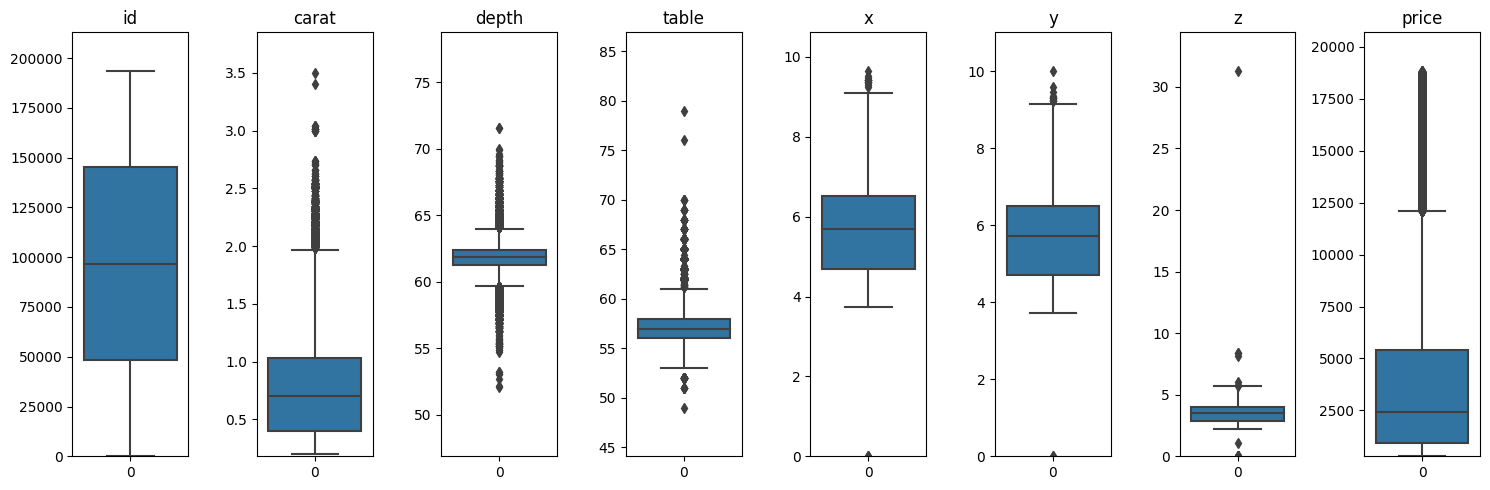

In [ ]:
# Filter numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Create subplots for each numeric column
fig, axs = plt.subplots(1, len(numeric_columns), figsize=(15, 5))

# Iterate over each numeric column and generate the boxplot
for i, column in enumerate(numeric_columns):
    sns.boxplot(data[column], ax=axs[i])
    axs[i].set_title(column)

    # Determine the y-axis limits for scaling
    min_val = data[column].min()
    max_val = data[column].max()
    ylim = (min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))
    axs[i].set_ylim(ylim)

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


Based on the boxplots above, we can see that there are decent number of outliers. For now, we will leave the outliers alone, but we could handle them in some if we choose.

In [ ]:
def remove_outliers(data):
  # Display shape before removing outliers
  print("Shape before removing outliers:", data.shape)

  original_num_samples = data.shape[0]

  # Select numeric columns
  numeric_columns = data.select_dtypes(include='number').columns.drop('price')

  # Calculate the IQR for each numeric column
  Q1 = data[numeric_columns].quantile(0.25)
  Q3 = data[numeric_columns].quantile(0.75)
  IQR = Q3 - Q1

  # Define the threshold to identify outliers (e.g., 1.5 times the IQR)
  outlier_threshold = 1.5

  # Remove outliers from each numeric column
  data = data[~((data[numeric_columns] < (Q1 - outlier_threshold * IQR)) | (data[numeric_columns] > (Q3 + outlier_threshold * IQR))).any(axis=1)]

  # Display shape after removing outliers, so we can see how many samples remain
  print("Shape after removing outliers:", data.shape)

  print("Number of samples removed:", original_num_samples - data.shape[0])

  return data

Although scaling our numeric columns will not necessarily improve the accuracy for certain models, it will speed up their training. We will worry about speed later as our primary concern right now to set the ground for all the stuff to come and get a baseline accuracy and error. (Also, scaling values will mess up our relative scaling of the error calculation.)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scaler(data, type):
  numeric_data = data.select_dtypes(include=np.number)
  if type == "StandardScaler":
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()
  x_rescaled = scaler.fit_transform(numeric_data)
  return x_rescaled

def replace(data, new_x):
  for index, column in enumerate(data.select_dtypes(include=np.number)):
    data.loc[:, column] = new_x[:, index]

Based on our dataset, we can see that 8 features are numeric. We can try to implement dimensionality techniques such as Principle Component Analysis(PCA) to remove some of the unimportant numeric features. For now, we will not do this for the sake of simplicity, however, we can try this technique later and see if the model's performance improves.

In [ ]:
from sklearn.decomposition import PCA

def PCA(x):
  # Our number of features to keep will be determined by the model
  pca = PCA()

  x_transformed = pca.fit_transform(x)

  print(x_transformed.shape)

  return x_transformed

We will need to encode our categorical features if we want to use them to train our models
The one exception to this is we use catboost or lightbgm, which have their own categorical data processing.
(This is one preprocessing step we cannot skip)

In [ ]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()

categorical_columns = data.select_dtypes(include=[object])

for c in categorical_columns:
  data[c] = encode.fit_transform(data[c])

## **Model Training and Evaluation**


To start off, we will just use a Randomforest and Xgboost model and check their accuracies using a normal train-test-split. We will also stick to the default parameters for both the models.


In [ ]:
# We will import the necessary libraries for this task
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

x = data.drop(columns=['price'])
y = data.price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# It may seem unecessary to write functions just to create and train the models but it will be helpful later on
def create_train(model, x=None, y=None, params=None, training=True):
  if model == "rf":
    model = RandomForestRegressor(**params) if params is not None else RandomForestRegressor()
  elif model == "xgb":
    model = XGBRegressor(**params) if params is not None else XGBRegressor()

  if training:
    # assert x is None or y is None, "data for x and y should be provided"
    train(model, x, y)

  return model

def train(model, x, y):
  model.fit(x, y)

def evaluation(model, x, y, prin=True, ret=True):
  y_pred = model.predict(x)
  r2 = r2_score(y, y_pred)
  rmse = np.sqrt(mean_squared_error(y, y_pred))

  if prin:
    print(f'R2 Score of {model.__class__.__name__}: {r2}')
    print(f'Root Mean Squared Error of {model.__class__.__name__}: {rmse}')

  if ret:
    return r2, rmse


In [ ]:
rf = create_train('rf', x_train, y_train)
xgb = create_train('xgb', x_train, y_train)

evaluation(rf, x_test, y_test, ret=False)
print()
evaluation(xgb, x_test, y_test, ret=False)

R2 Score of RandomForestRegressor: 0.9777941879301824
Root Mean Squared Error of RandomForestRegressor: 599.1009692431385

R2 Score of XGBRegressor: 0.979296514618885
Root Mean Squared Error of XGBRegressor: 578.4801008130587


Our r2 scores are very high considering we did not do any feature engineering. However, the root mean squared error could use some work. We also did not implement cross-validation to get a better idea of our model's accuracy, so lets do that see if its consistent. For now, we will still stick to the default parameters.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=2)

models = [
    create_train('rf', training=False),
    create_train('xgb', training=False)
]

for model in models:
  fold_score1 = []
  fold_score2 = []
  for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train(model, x_train, y_train)

    print()

    r2, rmse = evaluation(model, x_test, y_test)

    fold_score1.append(r2)

    fold_score2.append(rmse)

  print(f'{model.__class__.__name__}:')
  print(f'Average R2 Score: {np.mean(fold_score1)}')
  print(f'Average Root Mean Squared Error: {np.mean(fold_score2)}')
  print()


R2 Score of RandomForestRegressor: 0.9779015070769028
Root Mean Squared Error of RandomForestRegressor: 599.6699515717288

R2 Score of RandomForestRegressor: 0.9764901854016661
Root Mean Squared Error of RandomForestRegressor: 617.6400715376996

R2 Score of RandomForestRegressor: 0.9776537078896106
Root Mean Squared Error of RandomForestRegressor: 605.5543657697806

R2 Score of RandomForestRegressor: 0.9779117706034768
Root Mean Squared Error of RandomForestRegressor: 602.3715273053976

R2 Score of RandomForestRegressor: 0.9774559003326899
Root Mean Squared Error of RandomForestRegressor: 601.4078992717915
RandomForestRegressor:
Average R2 Score: 0.9774826142608692
Average Root Mean Squared Error: 605.3287630912796


R2 Score of XGBRegressor: 0.9789965037945424
Root Mean Squared Error of XGBRegressor: 584.6241556208035

R2 Score of XGBRegressor: 0.9778113948794213
Root Mean Squared Error of XGBRegressor: 600.0340047408173

R2 Score of XGBRegressor: 0.9785434991352
Root Mean Squared Er

Now, lets start hyperparameter tuning and see if we can find the best possible parameters for our models. One thing to note is that this process alone is time-consuming, especially with a dataset of over 100k samples, it will take an extremely long time, especially if we include cross-validation. Doing this method might not be practical in every situation, but for the sake of hands on implementation, I will show how this would be done, especially when we do want the best accuracy. The time it takes for these models after each prediction as well as the final prediction will be logged so we can later compare and see if the potential accuracy gain was worth spending the time achieving it.

In [ ]:
import optuna
import time

def sampler(x, y, n):
  return x.sample(n), y.sample(n)

optuna.logging.set_verbosity(optuna.logging.WARNING)

time_logging = []
error_logging = []

def optimiz(model_name, x_train, y_train, x_test, y_test):
  prev_time = time.time()
  kf = KFold(n_splits=5, shuffle=True, random_state=2)
  def objective(trial):
      params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 20)
      }

      model = create_train(model_name, training=False)

      fold_score1 = []
      fold_score2 = []
      for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train(model, x_train, y_train)

        r2, rmse = evaluation(model, x_test, y_test, prin=False)

        fold_score1.append(r2)

        fold_score2.append(rmse)

      error_logging.append(np.mean(fold_score2))
      current_time = time.time() - prev_time
      time_logging.append(current_time)
      print(f'Average Root Mean Squraed Error: {np.mean(fold_score2)}')
      print(f'Current Time: {current_time}')
      return rmse

  n_trials = 10

  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=n_trials)

  print(f'{model_name}:')
  print(f'Best parameters: {study.best_params}')
  print(f'Best root mean squared error; {study.best_value}')
  print(time.time() - start, 's')

Average Root Mean Squraed Error: 590.0838632470346
Current Time: 88.45039463043213
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 174.6568489074707
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 261.90784645080566
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 349.1123125553131
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 433.9794542789459
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 521.331778049469
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 606.3426713943481
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 693.6946270465851
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 778.7673299312592
Average Root Mean Squraed Error: 590.0838632470346
Current Time: 866.2458071708679
xgb:
Best parameters: {'n_estimators': 191, 'max_depth': 17}
Best root mean squared error; 585.4032725513501
866.2492196559906 s


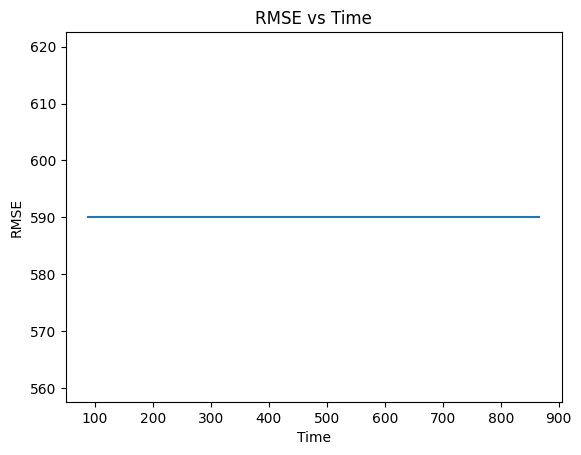

Average Root Mean Squraed Error: 605.4541735455424
Current Time: 548.7602071762085
Average Root Mean Squraed Error: 605.0173265765683
Current Time: 1096.8060801029205
Average Root Mean Squraed Error: 605.7038247624989
Current Time: 1641.5564496517181
Average Root Mean Squraed Error: 605.3430374891711
Current Time: 2188.368401527405
Average Root Mean Squraed Error: 605.0390652534901
Current Time: 2726.26065158844
Average Root Mean Squraed Error: 605.4225005692309
Current Time: 3265.2527055740356
Average Root Mean Squraed Error: 605.2805564216244
Current Time: 3802.683500766754
Average Root Mean Squraed Error: 605.4977076399019
Current Time: 4340.587879419327
Average Root Mean Squraed Error: 605.4946307251903
Current Time: 4878.294660568237
Average Root Mean Squraed Error: 605.5179565938458
Current Time: 5416.232330560684
rf:
Best parameters: {'n_estimators': 20, 'max_depth': 17}
Best root mean squared error; 602.0789634990429
5416.297575473785 s


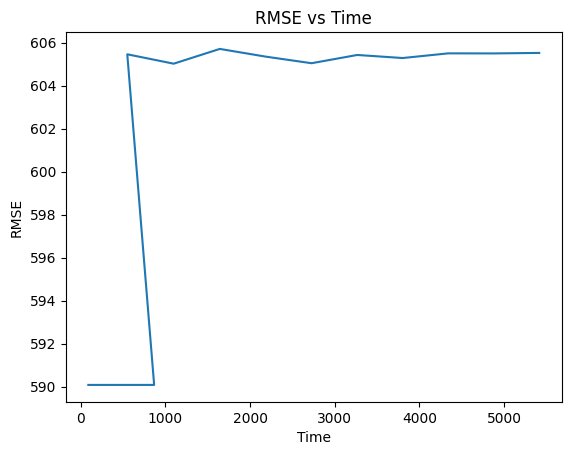

In [ ]:
start = time.time()
optimiz('xgb', x_train, y_train, x_test, y_test)
plt.plot(time_logging, error_logging)
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("RMSE vs Time")
plt.show()
start = time.time()
optimiz('rf', x_train, y_train, x_test, y_test)
plt.plot(time_logging, error_logging)
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("RMSE vs Time")
plt.show()

Given the time spent finding the right hyperparameters, there was no error drop. This is something to keep in mind when hyperparameter tuning for medium-to-large datasets.

Next, we will try to implement stacking with the hyperparameters found by optuna to see if we can further improve our accuracy. This is when we not only have to worry about time, but also memory usage. Stacking can use a lot of memory, so to keep things in check, we will use 10 base models(5 random forests and 5 xgboosts).

However, even with this, colab's system ram is not enough. Although restarting the runtime does indeed fix this issue(where we would only import the libraries, load the data, encode the categorical variables, and make our train and test sets), the time required to train this stacked model is way more than its worth.

We have a few options here:
- Use a random sample of our data to train the models
- Lower the number of base models to like 4-6
- Remove some unimportant features or samples in the dataset
- Scaling the values in the numerical columns down
- Ignore this step completely

Ignoring this step is a viable option and that is what will happen as of now.

In [ ]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import LinearRegression
# import time

# base_models = []

# for i in range(4):
#   base_models.append((f'xgb{i}', XGBRegressor()))
#   base_models.append((f'rf{i}', RandomForestRegressor()))

# meta_model = LinearRegression()

# stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# start = time.time()
# stacking_model.fit(x_train, y_train)
# print(time.time() - start, 's')